## Imports

In [1]:
import os
import shutil
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm # loading bar
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import librosa

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, r2_score, f1_score

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from tensorflow.keras.utils import to_categorical

2024-04-18 08:48:17.170814: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 08:48:17.170937: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 08:48:17.279558: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Check if running on Kaggle
kaggle = ('KAGGLE_KERNEL_RUN_TYPE' in os.environ)
if kaggle:
    # Code specific to Kaggle
    print("Running on Kaggle!")
else:
    print("Not running on Kaggle.")

Running on Kaggle!


In [3]:
def extract_numbers(filename):
    filename = filename.split('.')[0] # remove extension

    split = filename.split('_')

    if len(split) > 1:
        return split[1]
    elif len(split) == 1:
        return split[0]

In [4]:
if kaggle:
    DATA_DIR = '../input/birdclef-2024/'
    OUTPUT_DIR = '/kaggle/working/'
    shutil.copy('../input/features/extracted_features.pickle', 'extracted_features.pickle')
else: # local work
    DATA_DIR = "../../data/raw/" 
    OUTPUT_DIR = "../../data/processed/"

TRAIN_AUDIO_DIR = os.path.join(DATA_DIR, "train_audio/")

train_csv_path = os.path.join(DATA_DIR, "train_metadata.csv")

# Testing
TEST_AUDIO_DIR = os.path.join(DATA_DIR,"test_soundscapes/")

# Load list of audio files by parsing the test_soundscape folder
test_file_list = sorted(os.listdir(TEST_AUDIO_DIR))
test_file_list = [file for file in test_file_list if file.endswith('.ogg')]  # Filter only ogg files

if len(test_file_list) == 0:   # replace test dir by unlabeled dir for testing
    TEST_AUDIO_DIR = os.path.join(DATA_DIR, "unlabeled_soundscapes/")
    test_file_list = sorted(os.listdir(TEST_AUDIO_DIR))
    test_file_list = [file for file in test_file_list if file.endswith('.ogg')]  # Filter only ogg files
    test_file_list = test_file_list[:5]  # Take only 5 elements to speed up debugging

test_number_list = [extract_numbers(file) for file in test_file_list]

print(f'Directory used for testing: {TEST_AUDIO_DIR}')
print(f'Number of test files: {len(test_file_list)}')

Directory used for testing: ../input/birdclef-2024/unlabeled_soundscapes/
Number of test files: 5


In [5]:
SAMPLE_RATE = 32000
NUM_CLASSES_TO_KEEP = 20
NUM_AUDIO_PER_LABEL = 30

## Data collection

In [6]:
data = pd.read_csv(train_csv_path)

# Add complete filepath
data['filepath'] = data.apply(lambda row: os.path.join(TRAIN_AUDIO_DIR, row['filename']), axis=1)

# # Filter out large files
# data['filesize'] = data.apply(lambda row: os.path.getsize(row['filepath']), axis=1)

In [7]:
# get classes before filtering
list_species = sorted(data.primary_label.unique())
num_classes = len(list_species)
num_classes

182

In [8]:
# filter out data with secondary label
data = data[data.secondary_labels == "[]"]

In [9]:
# filter data with good rating
data = data[data.rating > 3]

In [10]:
X_files = data['filepath'].values.reshape(-1, 1)
y = data['primary_label'].values

## Downsampling

In [11]:
def undersample_keep_minority(X, y, threshold, num_classes_to_keep):
    # Identify minority classes
    class_counts = {label: np.sum(y == label) for label in np.unique(y)}
    minority_classes = [label for label, count in class_counts.items() if count < threshold]
    
    # Determine majority classes
    majority_classes = [label for label, count in class_counts.items() if label not in minority_classes]
    
    # Randomly select minority and majority classes to keep
    num_minority_classes_to_keep = num_classes_to_keep // 2
    num_majority_classes_to_keep = num_classes_to_keep - num_minority_classes_to_keep
    
    minority_classes_to_keep = np.random.choice(minority_classes, size=num_minority_classes_to_keep, replace=False)
    majority_classes_to_keep = np.random.choice(majority_classes, size=num_majority_classes_to_keep, replace=False)
    
    # Identify instances of selected minority and majority classes
    minority_indices_to_keep = [idx for idx, label in enumerate(y) if label in minority_classes_to_keep]
    majority_indices_to_keep = [idx for idx, label in enumerate(y) if label in majority_classes_to_keep]
    
    # Randomly undersample majority classes
    undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
    X_majority, y_majority = undersampler.fit_resample(X[majority_indices_to_keep], y[majority_indices_to_keep])
    
    # Filter instances of minority classes to keep
    X_minority_to_keep = X[minority_indices_to_keep]
    y_minority_to_keep = y[minority_indices_to_keep]
    
    # Combine minority instances to keep and undersampled majority instances
    X_balanced = np.concatenate((X_minority_to_keep, X_majority), axis=0)
    y_balanced = np.concatenate((y_minority_to_keep, y_majority), axis=0)
    
    return X_balanced, y_balanced

In [12]:
X_files_undersampled, y_undersampled = undersample_keep_minority(X_files, y, threshold=NUM_AUDIO_PER_LABEL, num_classes_to_keep=NUM_CLASSES_TO_KEEP)
X_files_undersampled = X_files_undersampled[:,0]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


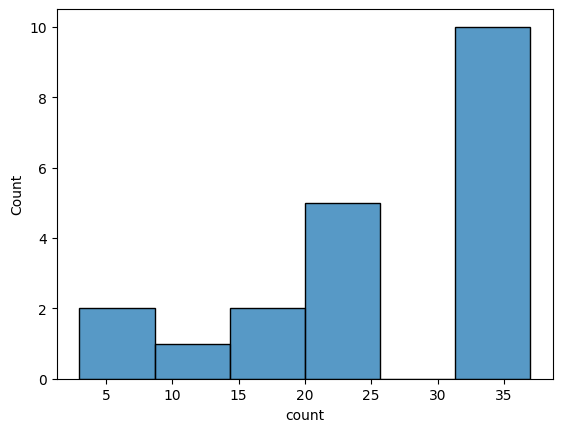

In [13]:
sns.histplot(pd.Series(y_undersampled).value_counts(), bins='rice');

## Features

In [14]:
def spectogram(audio_data, sample_rate=SAMPLE_RATE, n_mels=64, n_fft=1024, hop_len=None, top_db=80):
    
    spec = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)
    # spec = librosa.amplitude_to_db(spec, top_db=top_db)

    return spec

In [15]:
def normalize(X):
    # Compute mean and standard deviation along the time axis
    mean = np.mean(X, axis=1, keepdims=True)
    std = np.std(X, axis=1, keepdims=True)
    X = (X - mean) / std
    return X

In [16]:
def repeat_trunc(X, max_ms, sample_rate=SAMPLE_RATE):
    max_length = int(sample_rate // (max_ms / 1000))
    
    if X.shape[1] < max_length:
#         pad_width = max_length - X.shape[1]
#         X = np.pad(X, pad_width=((0, 0), (0, pad_width)), mode='constant')
        repeat_times = int(np.ceil(max_length / X.shape[1]))
        X = np.tile(X, (1, repeat_times))
        X = X[:, :max_length]  # Truncate to ensure the desired length
        
    # truncate X to ensure a fixed length
    elif X.shape[1] > max_length:
        X = X[:, :max_length]
        
        
    return X

In [17]:
def extract_features(audio_data):
    mfcc = librosa.feature.mfcc(y=audio_data, sr=SAMPLE_RATE, n_mfcc=40)
    
    return mfcc

In [18]:
def preprocess(audio_data):
    features = extract_features(audio_data)
    features = normalize(features)
    features = repeat_trunc(features, max_ms=10000)
    
    features = np.expand_dims(features, -1) # Adding number of channels for CNN (1)
    
    return features

In [19]:
def load_data_and_preprocess(X_files):
    X = []

    for filepath in tqdm(X_files, desc='Processing files', total=len(X_files)):
        # Process data with tqdm
        audio_data, _ = librosa.load(filepath, sr=SAMPLE_RATE)
        spec = preprocess(audio_data)
        X.append(spec)

    X = np.array(X)

    return X

In [20]:
X_undersampled = load_data_and_preprocess(X_files_undersampled)

Processing files: 100%|██████████| 544/544 [02:00<00:00,  4.52it/s]


In [21]:
# def extract_features(audio_data, sample_rate=SAMPLE_RATE, max_length=3000):
#     mfcc = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
    
#     # Compute mean and standard deviation along the time axis
#     mean_mfcc = np.mean(mfcc, axis=1, keepdims=True)
#     std_mfcc = np.std(mfcc, axis=1, keepdims=True)
    
#     # Center MFCC coefficient dimensions to the mean and unit variance
#     mfcc = (mfcc - mean_mfcc) / std_mfcc
    
#     # Pad or truncate mfccs to ensure a fixed length
#     if mfcc.shape[1] < max_length:
#         pad_width = max_length - mfcc.shape[1]
#         mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
#     elif mfcc.shape[1] > max_length:
#         mfcc = mfcc[:, :max_length]
    
#     return mfcc

In [22]:
# def extract_features(audio_data, sample_rate=SAMPLE_RATE, max_length=3000):
#     mfcc = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
    
#     # Compute mean and standard deviation along the time axis
#     mean_mfcc = np.mean(mfcc, axis=1, keepdims=True)
#     std_mfcc = np.std(mfcc, axis=1, keepdims=True)
    
#     # Center MFCC coefficient dimensions to the mean and unit variance
#     mfcc = (mfcc - mean_mfcc) / std_mfcc
    
#     # Repeat signal instead of padding
#     if mfcc.shape[1] < max_length:
# #         pad_width = max_length - mfcc.shape[1]
# #         mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
#         repeat_times = int(np.ceil(max_length / mfcc.shape[1]))
#         mfcc = np.tile(mfcc, (1, repeat_times))
#         mfcc = mfcc[:, :max_length]  # Truncate to ensure the desired length
        
#     # truncate mfcc to ensure a fixed length
#     elif mfcc.shape[1] > max_length:
#         mfcc = mfcc[:, :max_length]
    
#     return mfcc

In [23]:
# def load_data_and_extract_features(X_files, sample_rate=SAMPLE_RATE):
#     features_list = []

#     for filepath in tqdm(X_files, desc='Processing files', total=len(X_files)):
#         # Process data with tqdm
#         audio_data, _ = librosa.load(filepath, sr=sample_rate)
#         features = extract_features(audio_data, sample_rate=sample_rate)
#         features_list.append(features)

#     X = np.array(features_list)

#     return X

In [24]:
# X_undersampled = load_data_and_extract_features(X_files_undersampled)

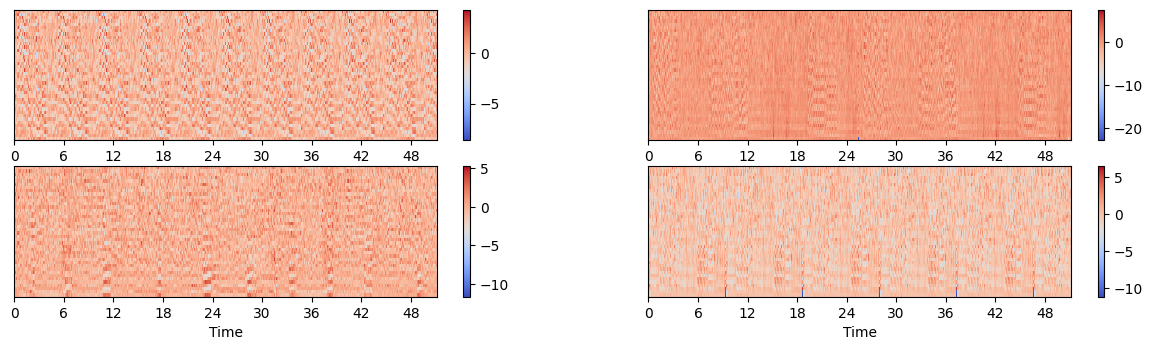

In [33]:
plt.figure(figsize=(15, 20))

# Calculate the global minimum and maximum values for the colorbar
global_min = np.min(X_undersampled)
global_max = np.max(X_undersampled)

for i in range(4):
    plt.subplot(10, 2, i+1)
    librosa.display.specshow(X_undersampled[i,:,:,0], sr=SAMPLE_RATE, x_axis='time')
    plt.colorbar()
    # plt.colorbar(format='%+2.2f dB')


## Label Encoding

In [34]:
label_encoder = LabelEncoder()
y_undersampled_encoded = label_encoder.fit_transform(y_undersampled)
y_undersampled_cat = to_categorical(y_undersampled_encoded)

## Train test split and Balancing

In [35]:
# Split the data into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X_undersampled, y_undersampled_cat, test_size=0.2, random_state=42, stratify=y_undersampled_cat)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

In [36]:
# Rebalance after train test split!!
X_train_flatten = X_train.reshape(X_train.shape[0], -1) # flatten 2 last dimensions because over sampling requires 2D array, not 3D

ros = RandomOverSampler(random_state=42)
X_train_flatten_oversampled, y_train_oversampled = ros.fit_resample(X_train_flatten, y_train)

X_train_oversampled = X_train_flatten_oversampled.reshape(-1, *X_train.shape[1:])

In [37]:
X_train_oversampled.shape

(480, 40, 3200, 1)

In [38]:
y_train_oversampled.shape

(480, 20)

## Model Training

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Define CNN architecture with BatchNormalization
def create_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [40]:
model = create_model(input_shape=X_train_oversampled.shape[1:], num_classes=NUM_CLASSES_TO_KEEP)
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 38, 3198, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 19, 1599, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 17, 1597, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 798, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 6, 796, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 611328)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │   156,500,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │         5,140 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,663,828 (597.63 MB)

 Trainable params: 156,663,828 (597.63 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

history = model.fit(X_train_oversampled, y_train_oversampled, batch_size=32, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 4:09 18s/step - accuracy: 0.1250 - loss: 2.9619

I0000 00:00:1713430357.720246      98 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713430357.739497      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.0823 - loss: 25.2504

W0000 00:00:1713430360.542702      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


15/15 ━━━━━━━━━━━━━━━━━━━━ 27s 629ms/step - accuracy: 0.0824 - loss: 24.4991 - val_accuracy: 0.0345 - val_loss: 3.0069
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step - accuracy: 0.2448 - loss: 2.7941 - val_accuracy: 0.1034 - val_loss: 2.9901
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.3752 - loss: 2.1173 - val_accuracy: 0.0805 - val_loss: 2.8231
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step - accuracy: 0.6446 - loss: 1.3259 - val_accuracy: 0.1149 - val_loss: 2.8188
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 196ms/step - accuracy: 0.8269 - loss: 0.7241 - val_accuracy: 0.1264 - val_loss: 2.9214
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 0.9226 - loss: 0.3612 - val_accuracy: 0.1149 - val_loss: 3.3305
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step - accuracy: 0.9802 - loss: 0.1030 - val_accuracy: 0.1724 - val_loss: 3.3033
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.9963 - loss: 0.0447 - val_accuracy: 0.16

In [42]:
model.evaluate(X_test, y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.2187 - loss: 3.2928 


[3.2871041297912598, 0.19266055524349213]

In [43]:
def plot_history(history, metric='mae', title=None):
    # Setting figures
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))

    # Create the plots
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])

    ax2.plot(history.history[metric])
    ax2.plot(history.history['val_'+metric])

    # Set titles and labels
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')

    ax2.set_title(metric.capitalize())
    ax2.set_ylabel(metric.capitalize())
    ax2.set_xlabel('Epoch')

    # # Set limits for y-axes
    # ax1.set_ylim(ymin=0, ymax=200)
    # ax2.set_ylim(ymin=0, ymax=20)

    # Generate legends
    ax1.legend(['Train', 'Validation'], loc='best')
    ax2.legend(['Train', 'Validation'], loc='best')

    # Show grids
    ax1.grid(axis="x",linewidth=0.5)
    ax1.grid(axis="y",linewidth=0.5)

    ax2.grid(axis="x",linewidth=0.5)
    ax2.grid(axis="y",linewidth=0.5)

    if title:
        fig.suptitle(title)

    plt.show() 

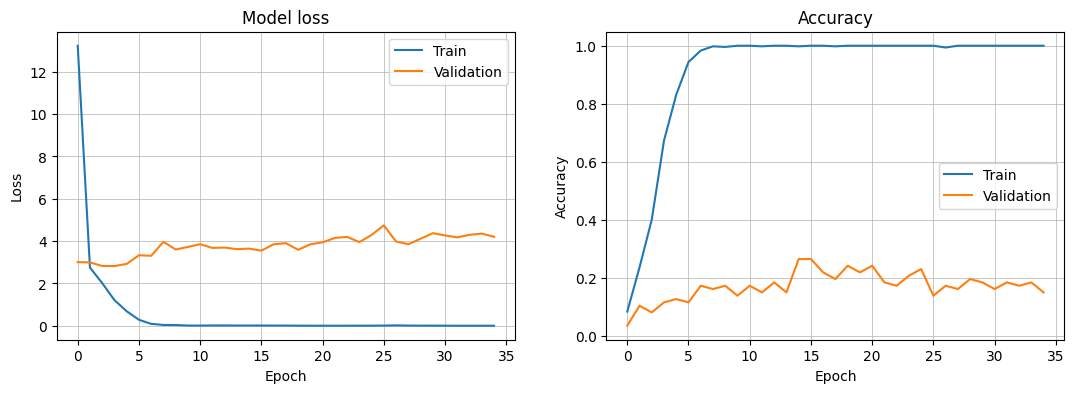

In [44]:
plot_history(history, metric='accuracy')

In [48]:
y_pred = model.predict(X_test)


roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
roc_auc

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step 

W0000 00:00:1713430457.806825      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step


0.6940185464906798

In [45]:
model.save('my_model.h5')

In [46]:
# from tensorflow.keras import models


# my_model = models.load_model('my_model.h5')
# my_model.predict(X_test)

## Testing and submission

In [49]:
# def evaluate_model(model, X, y_true, prefix=''):
#     y_pred = model.predict(X)
#     y_pred_proba = model.predict_proba(X)
    
#     metrics = {}
#     metrics['accuracy'] = accuracy_score(y_true, y_pred)
#     metrics['f1'] = f1_score(y_true, y_pred, average='macro')
#     metrics['roc_auc'] = roc_auc_score(y_true, y_pred_proba, average='macro', multi_class='ovr')
    
#     for key, value in metrics.items():
#         print(f'{prefix} {key} : {value:.2%}'.strip())
    
#     return metrics

In [50]:
# Function used later to write proba to df
def proba_df(y_pred_proba):
    y_pred_proba_df = pd.DataFrame(y_pred_proba, columns=label_encoder.classes_)
    results = pd.DataFrame({'row_id': row_id_list}) 
    results = pd.concat([results,  y_pred_proba_df], axis=1)

    # Reorder the columns to have 'row_id' first, followed by list_species
    columns_order = ['row_id'] + list_species
    results = results.reindex(columns=columns_order).fillna(0)
    
    return results

In [51]:
# Function to split audio file into chunks of given duration
def split_audio(path, duration, sr):
    sig, rate = librosa.load(path, sr=sr)
    chunk_size = duration * rate
    chunks = [sig[i:i+chunk_size] for i in range(0, len(sig), chunk_size)]
    return chunks

In [52]:
# This is where we will store our results
row_id_list = []
X_test = []

# Process audio files and make predictions with tqdm progress bar
for audio_file, file_number in tqdm(zip(test_file_list, test_number_list), total=len(test_file_list), desc='Processing test files'):
    path = os.path.join(TEST_AUDIO_DIR, audio_file)

    # Split audio file into 5-second chunks
    audio_chunks = split_audio(path, duration=5, sr=SAMPLE_RATE)

    for i, chunk in enumerate(audio_chunks):
        chunk = audio_chunks[i]
        chunk_end_time = (i + 1) * 5
        row_id = f"soundscape_{file_number}_{chunk_end_time}"
        row_id_list.append(row_id)

        features = preprocess(chunk)

        X_test.append(features)   

X_test = np.array(X_test) # convert list of 1D arrays to 2D array

Processing test files: 100%|██████████| 5/5 [00:08<00:00,  1.73s/it]


In [53]:
# Select model used for predictions
best_model = model

In [54]:
y_pred_proba = best_model.predict(X_test)
results = proba_df(y_pred_proba)
results

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 549ms/step


,row_id,asbfly,ashdro1,ashpri1,ashwoo2,asikoe2,asiope1,aspfly1,aspswi1,barfly1,...,whbwoo2,whcbar1,whiter2,whrmun,whtkin2,woosan,wynlau1,yebbab1,yebbul3,zitcis1
0,soundscape_1000170626_5,0.0,0.011730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.004426,0.0,0.0,0.0,0.0,0.0,0.0
1,soundscape_1000170626_10,0.0,0.075786,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.240208,0.0,0.0,0.0,0.0,0.0,0.0
2,soundscape_1000170626_15,0.0,0.005806,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.084309,0.0,0.0,0.0,0.0,0.0,0.0
3,soundscape_1000170626_20,0.0,0.039424,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.005034,0.0,0.0,0.0,0.0,0.0,0.0
4,soundscape_1000170626_25,0.0,0.001892,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.298191,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,soundscape_1000450112_220,0.0,0.010508,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.057720,0.0,0.0,0.0,0.0,0.0,0.0
236,soundscape_1000450112_225,0.0,0.002120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.011095,0.0,0.0,0.0,0.0,0.0,0.0
237,soundscape_1000450112_230,0.0,0.001079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.007196,0.0,0.0,0.0,0.0,0.0,0.0
238,soundscape_1000450112_235,0.0,0.002421,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.009670,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
# Convert our results to csv
results.to_csv("submission.csv", index=False)